# PAC sequences 
### import 

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.io as scio
import os
import pac
import mne
import pickle
import itertools
from numba import jit, cuda
import functools as ft
from scipy import io as scio

In [3]:
list_files_path_name = pd.read_csv('..//task_track_files//task_track_file_pac_sequences_ch.csv',usecols=['local_file_path','raw_data_file_name','preprocessed_one','PAC_sequences_v1','Group_file_type'])
num_task_file = list_files_path_name.shape[0]
list_files_path_name

,local_file_path,raw_data_file_name,preprocessed_one,PAC_sequences_v1,Group_file_type
0,sub-001\ses-01\eeg\,sub-001_ses-01_task-Rest_eeg.set,pre_sub-001_ses-01_task-Rest_eeg.set,PAC_sequences_selected_ch_sub-001_ses-01_task-...,PD_ON
1,sub-001\ses-02\eeg\,sub-001_ses-02_task-Rest_eeg.set,pre_sub-001_ses-02_task-Rest_eeg.set,PAC_sequences_selected_ch_sub-001_ses-02_task-...,PD_OFF
2,sub-002\ses-01\eeg\,sub-002_ses-01_task-Rest_eeg.set,pre_sub-002_ses-01_task-Rest_eeg.set,PAC_sequences_selected_ch_sub-002_ses-01_task-...,PD_ON
3,sub-002\ses-02\eeg\,sub-002_ses-02_task-Rest_eeg.set,pre_sub-002_ses-02_task-Rest_eeg.set,PAC_sequences_selected_ch_sub-002_ses-02_task-...,PD_OFF
4,sub-003\ses-01\eeg\,sub-003_ses-01_task-Rest_eeg.set,pre_sub-003_ses-01_task-Rest_eeg.set,PAC_sequence_selected_ch_sub-003_ses-01_task-R...,CTL
...,...,...,...,...,...
70,sub-046\ses-01\eeg\,sub-046_ses-01_task-Rest_eeg.set,pre_sub-046_ses-01_task-Rest_eeg.set,PAC_sequence_selected_ch_sub-046_ses-01_task-R...,CTL
71,sub-047\ses-01\eeg\,sub-047_ses-01_task-Rest_eeg.set,pre_sub-047_ses-01_task-Rest_eeg.set,PAC_sequence_selected_ch_sub-047_ses-01_task-R...,CTL
72,sub-048\ses-01\eeg\,sub-048_ses-01_task-Rest_eeg.set,pre_sub-048_ses-01_task-Rest_eeg.set,PAC_sequence_selected_ch_sub-048_ses-01_task-R...,CTL
73,sub-049\ses-01\eeg\,sub-049_ses-01_task-Rest_eeg.set,pre_sub-049_ses-01_task-Rest_eeg.set,PAC_sequence_selected_ch_sub-049_ses-01_task-R...,CTL


## Set parameter

In [5]:
Path = 'D:\Mastersharif\MasterProject\data\parkinsons-oddball'
montage = mne.channels.read_custom_montage('Standard-10-20-Cap81.locs')
# set timing for s200 and s201 and s202
tmax = 1.450
tmin = 0.250
num_sample_start = int(tmin/0.002)
num_sample_final = int(tmax/0.002)
periods = {'S200':[num_sample_start,num_sample_final],'S201':[num_sample_start,num_sample_final]}
tmin = -0.2
tmax = 1
num_sample_start = int(tmin/0.002)
num_sample_final = int(tmax/0.002)
periods['S202'] = (num_sample_start,num_sample_final)
baseline = {}
tb1 = 0.250
tb2 = 0.450
num_sample_start = tb1/0.002
num_sample_final = tb2/0.002
baseline['S200'] =(num_sample_start,num_sample_final)
baseline['S201'] = (num_sample_start,num_sample_final) 
tb1 = -0.2
tb2 = 0.0
num_sample_start = tb1/0.002
num_sample_final = tb2/0.002
baseline['S202'] = (num_sample_start,num_sample_final)

start_time = -200
end_time = 1000

nobaseline = False

High_fre = 30
Low_fre = 6

start_sample = np.int32((start_time+200)/2)

end_sample = np.int32((end_time+200)/2)

with open('..\data\channels_name.pkl', 'rb') as f:
        channels_name = pickle.load(f)

temp = list(map(lambda x: x in ['AF8','AF7','Fp1','Fp2'],channels_name))

t = np.where(temp)
index_selected_ch = t[0]
h=1


Traceback (most recent call last):
  File "_pydevd_bundle/pydevd_cython.pyx", line 1078, in _pydevd_bundle.pydevd_cython.PyDBFrame.trace_dispatch
  File "_pydevd_bundle/pydevd_cython.pyx", line 297, in _pydevd_bundle.pydevd_cython.PyDBFrame.do_wait_suspend
  File "C:\Users\Mohammad\anaconda3\envs\neuroscience\lib\site-packages\debugpy\_vendored\pydevd\pydevd.py", line 1949, in do_wait_suspend
    keep_suspended = self._do_wait_suspend(thread, frame, event, arg, suspend_type, from_this_thread, frames_tracker)
  File "C:\Users\Mohammad\anaconda3\envs\neuroscience\lib\site-packages\debugpy\_vendored\pydevd\pydevd.py", line 1984, in _do_wait_suspend
    time.sleep(0.01)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:

def PAC_sequences_cal():
   for j in np.arange(num_task_file):
      Path_to_load_file = os.path.join(Path,list_files_path_name['local_file_path'][j],list_files_path_name['preprocessed_one'][j])
      Path_to_save_file = os.path.join(Path,list_files_path_name['local_file_path'][j],list_files_path_name['PAC_sequences_v1'][j])
      if not os.path.isfile(Path_to_save_file):
         EEG = mne.io.read_raw_eeglab(Path_to_load_file,eog=(),preload=True)
         eeg_signals = EEG['data'][0]*np.array([1e6],dtype=np.float64)
         events, event_dict = mne.events_from_annotations(EEG, verbose=0)
         events = mne.pick_events(events,include=[event_dict['S200'],event_dict['S201'],event_dict['S202']])
         print(events.shape)
         eeg_trials = np.zeros(shape=(63,events.shape[0],601))
         # calculation of trials with basline correction
         for i,event_detail in enumerate(events):
            if event_detail[2] == event_dict['S200']:
               t = eeg_signals[:,event_detail[0]+periods['S200'][0]:event_detail[0]+periods['S200'][1]+1]
               t = t - np.expand_dims(np.mean(t[:,0:100],axis=1),axis=1) 
               eeg_trials[:,i,0:t.shape[1]] = t
            elif event_detail[2] == event_dict['S201']:
               t = eeg_signals[:,event_detail[0]+periods['S201'][0]:event_detail[0]+periods['S201'][1]+1] 
               t = t - np.expand_dims(np.mean(t[:,0:100],axis=1),axis=1) 
               eeg_trials[:,i,0:t.shape[1]] = t
            elif event_detail[2] == event_dict['S202']:
               t = eeg_signals[:,event_detail[0]+periods['S202'][0]:event_detail[0]+periods['S202'][1]+1] 
               t = t - np.expand_dims(np.mean(t[:,0:100],axis=1),axis=1) 
               eeg_trials[:,i,0:t.shape[1]] =  t  
         
         PAC_sequences = np.zeros(shape=[index_selected_ch.shape[0],eeg_trials.shape[1]])
         for k,ch in enumerate(index_selected_ch):
            for trial in np.arange(eeg_trials.shape[1]):
               PAC_sequences[k,trial] = pac.tfMVL(eeg_trials[ch,trial,start_sample:end_sample+1],high_freq=[High_fre,High_fre],low_freq=[Low_fre,Low_fre],Fs=500)
      
         np.save(Path_to_save_file,PAC_sequences)
      
      # compare the ERP calculation using the above EEG trials with ERP in mne
      # indexes = np.nonzero([events[:,2]==event_dict['S200']])
      # temp = eeg_trials[:,indexes[1],:]
      # ERP1['S200'] = np.mean(temp,axis=1)

      # indexes = np.nonzero([events[:,2]==event_dict['S201']])
      # temp = eeg_trials[:,indexes[1],:]
      # ERP1['S201'] = np.mean(temp,axis=1)

      # indexes = np.nonzero([events[:,2]==event_dict['S202']])
      # temp = eeg_trials[:,indexes[1],:]
      # ERP1['S202'] = np.mean(temp,axis=1)
      # t  = events[events[:,2]==5]
      #     # t1 = mne.pick_events(events,include=[5])
      # t2 = {'S200':5}
      # pochs_1 = mne.Epochs(EEG,events=t,event_id=t2,
      #                 tmin=0.250, tmax=1.450, baseline=(0.250,0.450),preload=True, verbose=0)
      # ERP['S200'] = pochs_1['S200'].average().to_data_frame()
      # del ERP['S200']['time']
      # ERP_array[0,:,:] = np.transpose(ERP['S200'].to_numpy())
      
      # t  = events[events[:,2]==6]
      # t2 = {'S201':6}
      # pochs_1 = mne.Epochs(EEG,events=t,event_id=t2,
      #                 tmin=0.250, tmax=1.450, baseline=(0.250,0.450),preload=True, verbose=0) 
      # ERP['S201'] = pochs_1['S201'].average().to_data_frame() 
      # del ERP['S201']['time']
      # ERP_array[1,:,:] = np.transpose(ERP['S201'].to_numpy())

      # t  = events[events[:,2]==7]
      # t2 = {'S202':7}               
      # pochs_1 = mne.Epochs(EEG,events=t,event_id=t2,
      #                 tmin=-0.2, tmax=1, baseline=(-0.2,0.0),preload=True, verbose=0)  
      # ERP['S202'] = pochs_1['S202'].average().to_data_frame() 
      # del ERP['S202']['time']
      # ERP_array[2,:,:] = np.transpose(ERP['S202'].to_numpy())

if __name__=="__main__":
    PAC_sequences_cal()

    # np.save(f'..\data\PAC_electordes_{start_time}_{end_time}_pair_fre_{High_fre}_{Low_fre}_nb_{nobaseline}',PAC_on_electrodes)   

## PAC sequence plot for all subjects
### Load PAC sequences

In [30]:
Path = 'D:\Mastersharif\MasterProject\data\parkinsons-oddball'
nobaseline = False
minimum_number_trials = 100
selected_number_channel = 4
PAC_sequences_collection = np.zeros([3,25,selected_number_channel,minimum_number_trials])
list_files_path_name.shape[0]
counter_PD_on = 0
counter_PD_off = 0
counter_CTL = 0
for i in np.arange(num_task_file):
    Path_to_save_file = os.path.join(Path,list_files_path_name['local_file_path'][i],list_files_path_name['PAC_sequences_v1'][i])
    PAC_sequences = np.load(Path_to_save_file)
    if PAC_sequences.shape[1]< minimum_number_trials:
        continue
    PAC_sequences = PAC_sequences[:,0:minimum_number_trials]
    if list_files_path_name['Group_file_type'][i] == 'PD_ON':
        PAC_sequences_collection[0,counter_PD_on,:,:] = PAC_sequences
        counter_PD_on = counter_PD_on + 1
    elif list_files_path_name['Group_file_type'][i] == 'PD_OFF':
        PAC_sequences_collection[1,counter_PD_off,:,:] = PAC_sequences
        counter_PD_off = counter_PD_off + 1
    elif list_files_path_name['Group_file_type'][i] == 'CTL':
        PAC_sequences_collection[2,counter_CTL,:,:] = PAC_sequences
        counter_CTL = counter_CTL + 1

### Plot grand mean PAC sequences

(3, 4, 100)


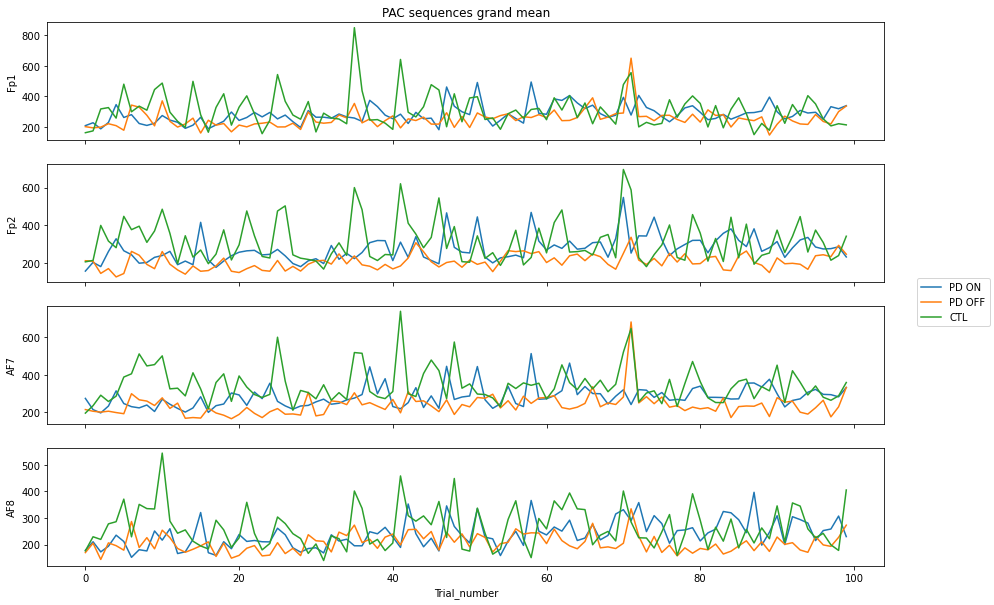

In [5]:
select_channels = [channels_name[i] for i in index_selected_ch]
PAC_sequences_grand_mean = np.mean(PAC_sequences_collection,axis=1)
print(PAC_sequences_grand_mean.shape)
fig, ax = plt.subplots(4,1,sharex=True,figsize=(15, 10))
for i in np.arange(4):
    for j in np.arange(3):
        ax[i].plot(PAC_sequences_grand_mean[j,i,:])
    ax[i].set_ylabel(select_channels[i])     

ax[0].set_title('PAC sequences grand mean')
ax[3].set_xlabel('Trial_number')
fig.legend(['PD ON','PD OFF', 'CTL'],loc='center right')



## Calculation of target number for each trial over the subject of each group

In [22]:
Path_to_digit_sequences = 'D:\Mastersharif\MasterProject\data\parkinsons-oddball\EEG_feature\digit_sequences'
Target_number_stimuli = np.zeros(shape=[3,100])
for i in np.arange(num_task_file):
    Temp = list_files_path_name['raw_data_file_name'][i][0:-4]
    Path = os.path.join(Path_to_digit_sequences,Temp,'digit_sequences.npy')
    Digit_sequences = np.load(Path)
    if list_files_path_name['Group_file_type'][i] == 'PD_ON' and Digit_sequences.shape[0]>=100:
       Target_number_stimuli[0,:] += (Digit_sequences[0:100]==1)
    elif list_files_path_name['Group_file_type'][i] == 'PD_OFF' and Digit_sequences.shape[0]>=100:
       Target_number_stimuli[1,:] += (Digit_sequences[0:100]==1) 
    elif list_files_path_name['Group_file_type'][i] == 'CTL' and Digit_sequences.shape[0]>=100:
       Target_number_stimuli[2,:] += (Digit_sequences[0:100]==1)       
    




### necessary function

In [32]:
def format_func_ctl(value, tick_number):
    # find number of multiples of pi/2
    return f'{Target_number_stimuli[2,tick_number]}'

(3, 4, 100)


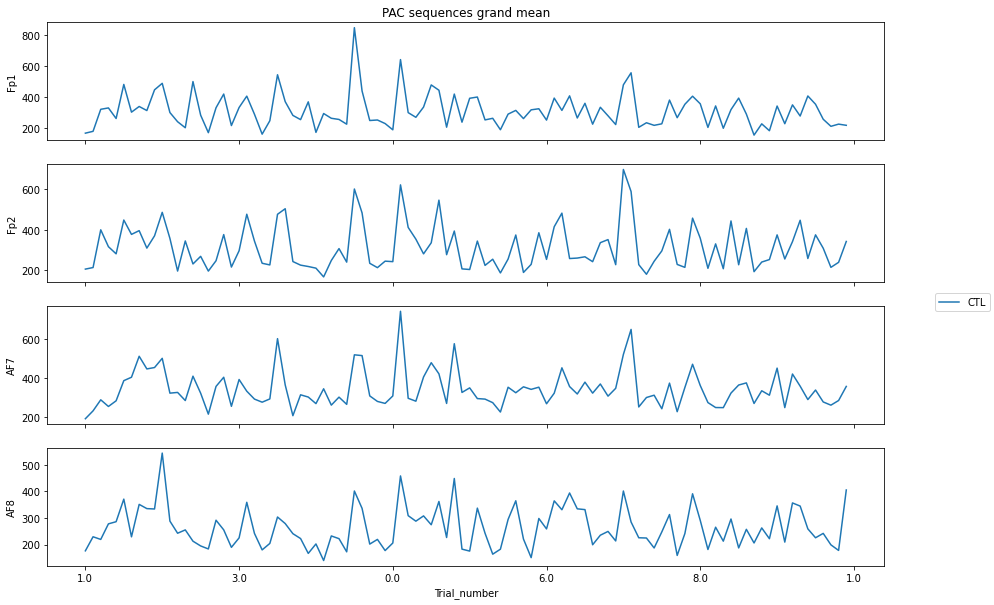

In [33]:
select_channels = [channels_name[i] for i in index_selected_ch]
PAC_sequences_grand_mean = np.mean(PAC_sequences_collection,axis=1)
print(PAC_sequences_grand_mean.shape)
fig, ax = plt.subplots(4,1,sharex=True,figsize=(15, 10))
for i in np.arange(4):
    ax[i].plot(PAC_sequences_grand_mean[2,i,:])
    ax[i].set_ylabel(select_channels[i])     

ax[3].xaxis.set_major_formatter(plt.FuncFormatter(format_func_ctl))
ax[0].set_title('PAC sequences grand mean')
ax[3].set_xlabel('Trial_number')
fig.legend(['CTL'],loc='center right')

array([[1.        , 0.03571331],
       [0.03571331, 1.        ]])

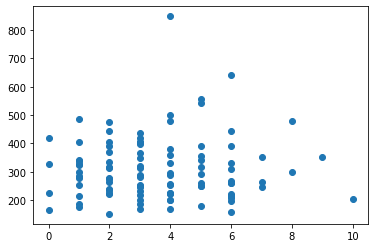

In [46]:
plt.scatter(Target_number_stimuli[2,:],PAC_sequences_grand_mean[2,0,:])
Target_number_stimuli[2,78]
np.corrcoef(Target_number_stimuli[2,:],PAC_sequences_grand_mean[2,0,:])
# np.mean(Target_number_stimuli,axis=1)

## Plot emprical condition PAC on traget stimulus

In [45]:
Path = 'D:\Mastersharif\MasterProject\data\parkinsons-oddball'
Path_to_digit_sequences = 'D:\Mastersharif\MasterProject\data\parkinsons-oddball\EEG_feature\digit_sequences'
nobaseline = False
minimum_number_trials = 100
selected_number_channel = 4
PAC_sequences_conditional_mean = np.zeros([3,3,selected_number_channel,minimum_number_trials])
list_files_path_name.shape[0]
counter_PD_on = 0
counter_PD_off = 0
counter_CTL = 0

counter = np.zeros(shape=[3,3,1,100])
for i in np.arange(num_task_file):
    Path_to_save_file = os.path.join(Path,list_files_path_name['local_file_path'][i],list_files_path_name['PAC_sequences_v1'][i])
    PAC_sequences = np.load(Path_to_save_file)
    if PAC_sequences.shape[1]< minimum_number_trials:
        continue
    PAC_sequences = PAC_sequences[:,0:minimum_number_trials]
    Temp = list_files_path_name['raw_data_file_name'][i][0:-4]
    Path_to_sequences_file = os.path.join(Path_to_digit_sequences,Temp,'digit_sequences.npy')
    Digit_sequences = np.load(Path_to_sequences_file)
    if list_files_path_name['Group_file_type'][i] == 'PD_ON':
        for j in np.arange(3):
            temp1 = Digit_sequences[0:100]==(j+1)
            temp = PAC_sequences * (temp1)
            temp3 = counter[0,j,0,:]+temp1
            temp3[temp3==0] = 1
            PAC_sequences_conditional_mean[0,j,:,:] = (counter[0,j,0,:] * PAC_sequences_conditional_mean[0,j,:,:] + temp)/(temp3)
            counter[0,j,0,:] += (temp1)
    elif list_files_path_name['Group_file_type'][i] == 'PD_OFF':
        for j in np.arange(3):
            temp1 = Digit_sequences[0:100]==(j+1)
            temp = PAC_sequences * (temp1)
            temp3 = counter[1,j,0,:]+temp1
            temp3[temp3==0] = 1
            PAC_sequences_conditional_mean[1,j,:,:] = (counter[1,j,0,:] * PAC_sequences_conditional_mean[1,j,:,:] + temp)/(temp3)
            counter[1,j,0,:] += (temp1)    
    elif list_files_path_name['Group_file_type'][i] == 'CTL':
        for j in np.arange(3):
            temp1 = Digit_sequences[0:100]==(j+1)
            temp = PAC_sequences * (temp1)
            temp3 = counter[2,j,0,:]+temp1
            temp3[temp3==0] = 1
            PAC_sequences_conditional_mean[2,j,:,:] = (counter[2,j,0,:] * PAC_sequences_conditional_mean[2,j,:,:] + temp)/(temp3)
            counter[2,j,0,:] += (temp1)
        

In [43]:
np.max(PAC_sequences_conditional_mean)


5.987679859756922e+16

In [24]:
a = np.array([1,2,4]) / np.array([1,23,5])
a

array([1.        , 0.08695652, 0.8       ])

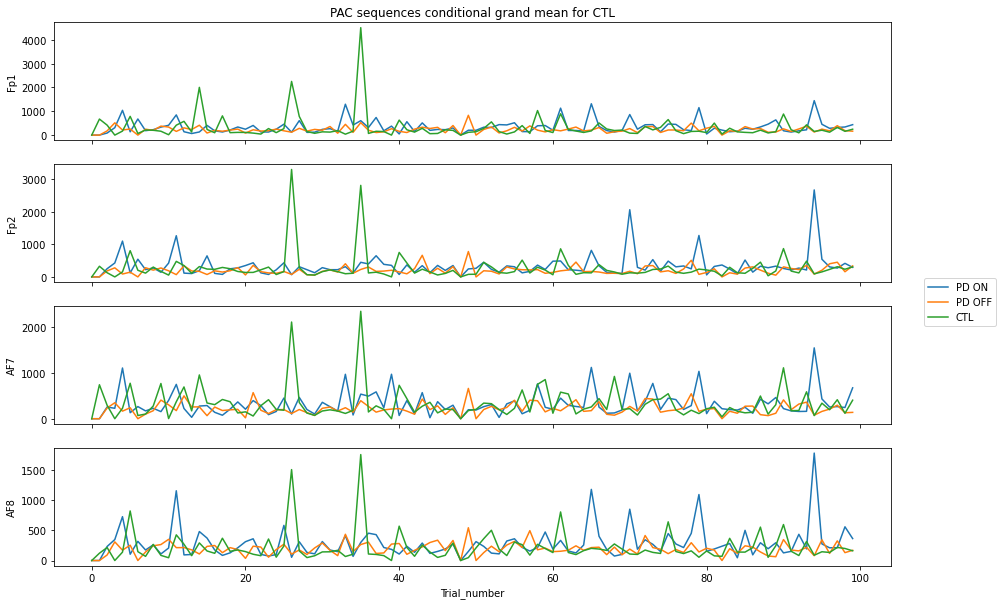

In [49]:
select_channels = [channels_name[i] for i in index_selected_ch]


fig, ax = plt.subplots(4,1,sharex=True,figsize=(15, 10))
for i in np.arange(4):
    ax[i].plot(PAC_sequences_conditional_mean[0,0,i,:])
    ax[i].plot(PAC_sequences_conditional_mean[1,0,i,:])
    ax[i].plot(PAC_sequences_conditional_mean[2,0,i,:])
    ax[i].set_ylabel(select_channels[i])     


ax[0].set_title('PAC sequences conditional grand mean for CTL')
ax[3].set_xlabel('Trial_number')
fig.legend(['PD ON','PD OFF','CTL'],loc='center right')

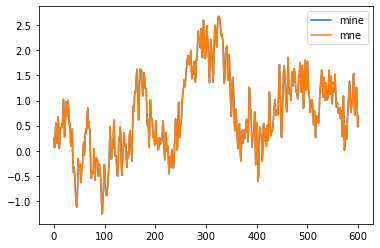

In [135]:
ch_num = 62
event_num = 1

# plt.plot(eeg_trials[ch_num,trial_num,:])

# plt.plot(ERP_array[event_num,ch_num,:])
events = ['S200','S201','S202']


Vmax = np.max(ERP1[events[event_num]][ch_num,:])
Vmin = np.min(ERP1[events[event_num]][ch_num,:])

temp = (ERP1[events[event_num]][ch_num,:]-Vmin)/(Vmax-Vmin)
# plt.plot(temp)
plt.plot(ERP1[events[event_num]][ch_num,:])

Vmax = np.max(ERP_array[event_num,ch_num,:])
Vmin = np.min(ERP_array[event_num,ch_num,:])

temp1 = (ERP_array[event_num,ch_num,:]-Vmin)/(Vmax-Vmin)

# plt.plot(temp1)
plt.plot(ERP_array[event_num,ch_num,:])

plt.legend(['mine','mne'])

0.06868210204433223